In [1]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp

In [2]:
def inf_line_bessel_oriented10(k,nx,t,alpha,theta,gamma,l):
    domain = np.arange(0, nx) - nx//2
    prob = np.zeros([nx,1], dtype='complex')
    for x in range(1,nx):
        prob[x,0] = ( (np.cos(theta)**2) * (sp.jv(domain[x] + k, 2*t)**2)
                     + (np.sin(theta)**2) * (sp.jv(domain[x] - k, 2*t)**2)
                     + 2*((-1)**k)*np.cos(2*alpha*k + gamma)*np.cos(theta)*np.sin(theta)*sp.jv(domain[x] + k, 2*t)*sp.jv(domain[x] - k, 2*t))

    return prob

def getMultipleProbs(k,n,theta,l,gamma,alphaList,timeList):
    timeListList = [timeList]*len(alphaList)
    probListAux = []
    probList = []

    for alpha in alphaList:
        for t in timeList:
            psi_oriented = inf_line_bessel_oriented10(k,n,t,alpha,theta,gamma,l)
            probListAux.append(np.sum(psi_oriented[n//2-k-1:n//2+k+2]))
        probList.append(probListAux)
        probListAux = []

    return probList

def getWeightedGraph(graph,weight):
    auxGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
        mat = np.matrix(d["weight"])
    for u,v,d in auxGraph.edges(data=True):
        d["weight"] = np.conj(weight)
        mat = np.matrix(d["weight"])
    return nx.compose(graph,auxGraph)



In [3]:
n=200
alpha=np.pi/2
# alpha=0
weight = np.exp(1j*alpha)
baseGraph = nx.path_graph(n,create_using=nx.DiGraph)

graph = getWeightedGraph(baseGraph,weight)
print(graph)

DiGraph with 200 nodes and 398 edges


In [13]:
k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
l = 0
gamma = l * np.pi


In [14]:
t = 35
initCond = [(n//2-k,(np.cos(theta))),(n//2+k,(np.exp(1j*gamma)*np.sin(theta)))]

qw = QWAK(graph)
qw.runWalk(t,customStateList=initCond)


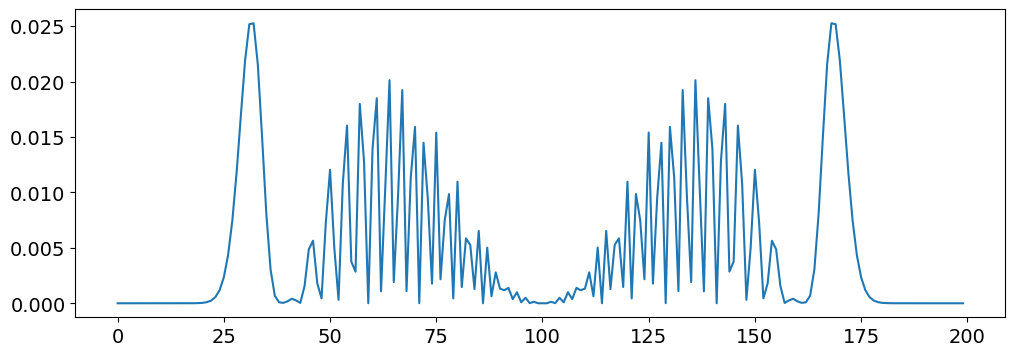

In [15]:
plt.plot(qw.getProbVec())

200


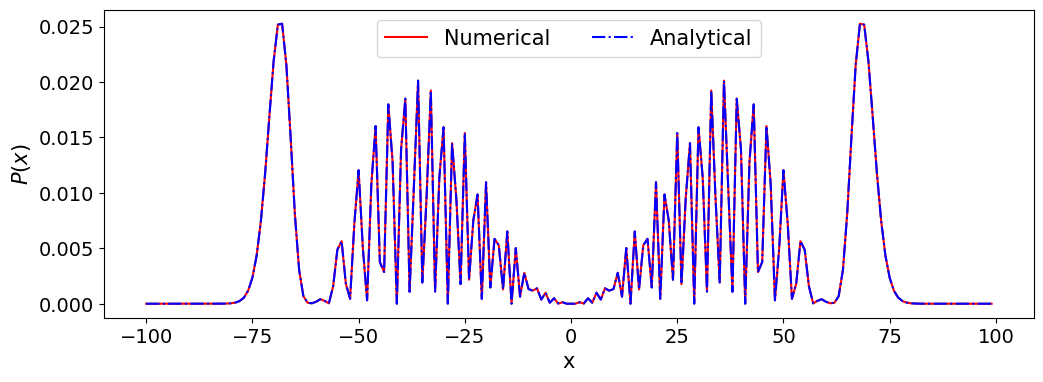

In [16]:
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

qwakProbDist = qw.getProbVec()
mpl.rcParams['figure.figsize'] = [12, 4]

besselProbDist = inf_line_bessel_oriented10(k,200,t,alpha,theta,gamma,l)
print(len(besselProbDist))
plt.plot(range(-100,100),qwakProbDist,label="Numerical",linestyle='solid',color='red')
plt.plot(range(-100,100),besselProbDist,label='Analytical',linestyle='dashdot',color='blue')
plt.ylabel(r"$P(x)$",fontsize=15)
plt.xlabel("x",fontsize=15)
plt.legend(loc="upper center",ncol=2,fontsize=15)

plt.savefig(fname='numAnalyt.png')

In [ ]:
survProb = qw.getSurvivalProb(n//2-k,n//2+k)
print(survProb)

In [ ]:
timeList = np.linspace(10,100,100)
qw.runMultipleWalks(timeList)

probDistList = qw.getProbDistList()
survProbList = qw.getSurvivalProbList(n//2-k-1,n//2+k+1)

# survProbList2 = getMultipleProbs(k,n,theta,l,gamma,[alpha],timeList)
# plt.plot(survProbList2[0],label="Bessel")

plt.loglog()
plt.plot(survProbList,label="QWAK")
plt.legend()
plt.xlim(5,100)

ImportError: attempted relative import with no known parent package